# Analýza průměrné mzdy v evropských zemích

In [ ]:
library(eurostat)
library(vtable)
library(ggplot2)
library(reshape2)
library(lmtest)
library(olsrr)
library(corrplot)
library(Sleuth2)
library(dplyr)
library(cowplot)
library(repr)
library(mgcv)
library(car)

## Úloha 1:
- Krátce prezentujte rozdělení průměrných mezd a jeho charakteristiky číselně i graficky.
- Diskutujte, které údaje o zemích by mohly mít na průměrné mzdy vliv.

Načtení datového rámce z Eurostat databáze:

In [2]:
df <- get_eurostat("nama_10_fte")
head(df)

Table nama_10_fte cached at /var/folders/qn/3pwbt2c16lxcqj8ryk_bq38h0000gn/T//Rtmpl2o7sn/eurostat/7cb6b2a8b67dda9ab5a0afc7caa2a87e.rds



freq,unit,geo,TIME_PERIOD,values
<chr>,<chr>,<chr>,<date>,<dbl>
A,EUR,AT,1995-01-01,26543
A,EUR,AT,1996-01-01,26522
A,EUR,AT,1997-01-01,25943
A,EUR,AT,1998-01-01,26863
A,EUR,AT,1999-01-01,27714
A,EUR,AT,2000-01-01,28415


In [3]:
unique(df$unit)

[1] "EUR" "NAC"

In [4]:
unique(df$geo)

[1] "AT"        "BE"        "BG"        "CY"        "CZ"        "DE"       
 [7] "DK"        "EA20"      "EE"        "EL"        "ES"        "EU27_2020"
[13] "FI"        "FR"        "HR"        "HU"        "IE"        "IT"       
[19] "LT"        "LU"        "LV"        "MT"        "PL"        "PT"       
[25] "RO"        "SE"        "SI"        "SK"

**Dataset obsahuje kódy zemí a agregáty (např. EA20, EU27_2020)**

Vyfiltrování datového rámce tak, aby obsahoval pouze řádky s měnovou jednotkou "EUR", dále filtrujeme data tak, aby zůstaly pouze záznamy z roku 2014:

In [5]:
df <- df[df$unit == "EUR", ] 
df_2014 <- df[format.Date(df$TIME_PERIOD, "%Y") == "2014",]
head(df_2014)

freq,unit,geo,TIME_PERIOD,values
<chr>,<chr>,<chr>,<date>,<dbl>
A,EUR,AT,2014-01-01,40927
A,EUR,BE,2014-01-01,43898
A,EUR,BG,2014-01-01,6025
A,EUR,CY,2014-01-01,20947
A,EUR,CZ,2014-01-01,11916
A,EUR,DE,2014-01-01,38692


In [6]:
mzdy_2014 <- df_2014 %>% select(geo, values) %>% rename(mzda = values)

Vytváříme pomocnou tabulku, která převádí kódy zemí (např. "AT") na jejich názvy (např. "Rakousko"). Dále odstraníme kódy, které označují agregovaná data, jako jsou "EA20" (Eurozóna) nebo "EU27_2020" (EU bez Spojeného království), protože nás zajímají pouze jednotlivé země.

In [7]:
mzdy_2014 <- mzdy_2014[(nchar(mzdy_2014$geo) == 2) & (mzdy_2014$geo != "EA") & (mzdy_2014$geo != "EU"), ]

zeme_kody <- data.frame(
  geo = c("AT", "BE", "BG", "CY", "CZ", "DE", "DK", "EE", "EL", "ES", "FI", "FR", 
         "HR", "HU", "IE", "IT", "LT", "LU", "LV", "MT", "PL", "PT", "RO", 
         "SE", "SI", "SK"),
  zeme = c("Rakousko", "Belgie", "Bulharsko", "Kypr", "Česká republika", "Německo", 
          "Dánsko", "Estonsko", "Řecko", "Španělsko", "Finsko", "Francie", 
          "Chorvatsko", "Maďarsko", "Irsko", "Itálie", "Litva", "Lucembursko", 
          "Lotyšsko", "Malta","Polsko", "Portugalsko", "Rumunsko", 
          "Švédsko", "Slovinsko", "Slovensko")
)

mzdy_2014 <- mzdy_2014 %>% left_join(zeme_kody, by = "geo")

In [8]:
print("Základní statistiky průměrných ročních mezd v evropských zemích (2014):")
summary(mzdy_2014$mzda)

sd_mzdy <- sd(mzdy_2014$mzda, na.rm = TRUE)
cv_mzdy <- sd_mzdy / mean(mzdy_2014$mzda, na.rm = TRUE) * 100
print(paste("Směrodatná odchylka:", round(sd_mzdy, 2)))
print(paste("Variační koeficient:", round(cv_mzdy, 2), "%"))

[1] "Základní statistiky průměrných ročních mezd v evropských zemích (2014):"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   6025   11919   21168   25477   39816   60639 

[1] "Směrodatná odchylka: 16048.66"
[1] "Variační koeficient: 62.99 %"


### Číselné charakteristiky:

- Průměrná hodnota mezd se pohybuje kolem 25 000 EUR ročně
- Medián je přibližně 21 000 EUR ročně, což naznačuje mírné zešikmení distribuce doprava
- Minimální hodnoty se pohybují kolem 5 000-7 000 EUR (východoevropské země)
- Maximální hodnoty dosahují až 60 000 EUR (severské země a Lucembursko)
- Směrodatná odchylka je vysoká (přibližně 16 000 EUR), což indikuje vysokou variabilitu mezd mezi zeměmi
- Variační koeficient okolo 63 % potvrzuje významnou relativní variabilitu

### Vizualizace

Vytváříme histogram, který ukazuje rozložení průměrných ročních mezd (v EUR) mezi evropskými zeměmi v roce **2014**:

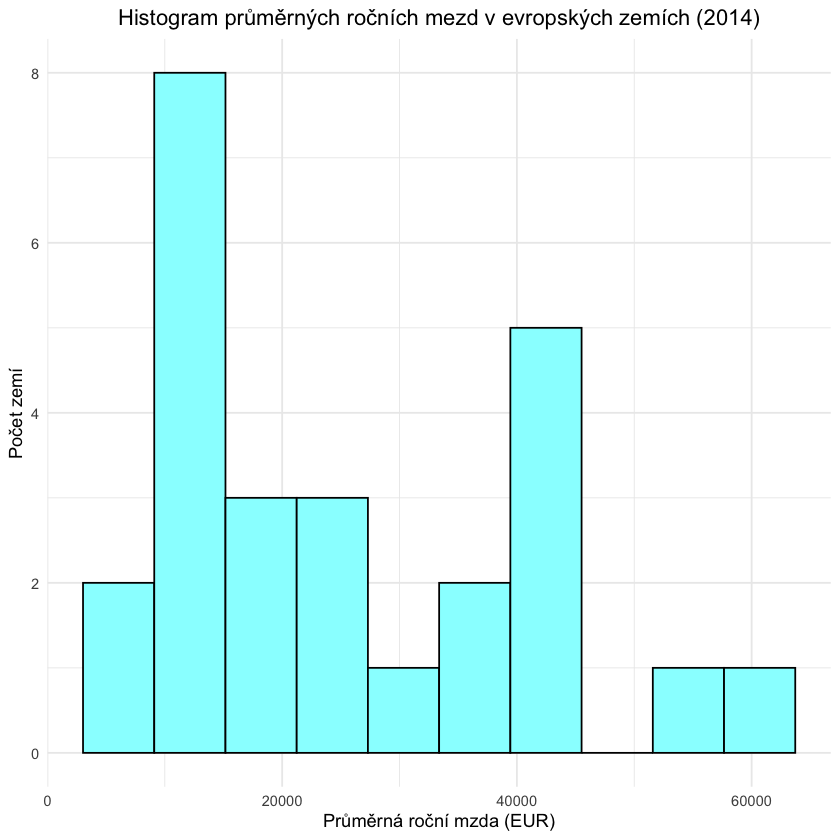

In [9]:
hist_mzdy <- ggplot(mzdy_2014, aes(x = mzda)) +
  geom_histogram(bins = 10, fill = "darkslategray1", color = "black") +
  labs(title = "Histogram průměrných ročních mezd v evropských zemích (2014)",
       x = "Průměrná roční mzda (EUR)",
       y = "Počet zemí") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5))
print(hist_mzdy)

Z tohoto histogramu vidíme, že většina mezd v evropských zemích v roce 2014 leží blíže k minimu, což naznačuje **pravostrannou šikmost rozdělení**.

Vytváříme krabicový graf, který shrnuje rozložení průměrných ročních mezd v evropských zemích v roce **2014** — ukazuje medián, kvartily, rozsah a případné odlehlé hodnoty

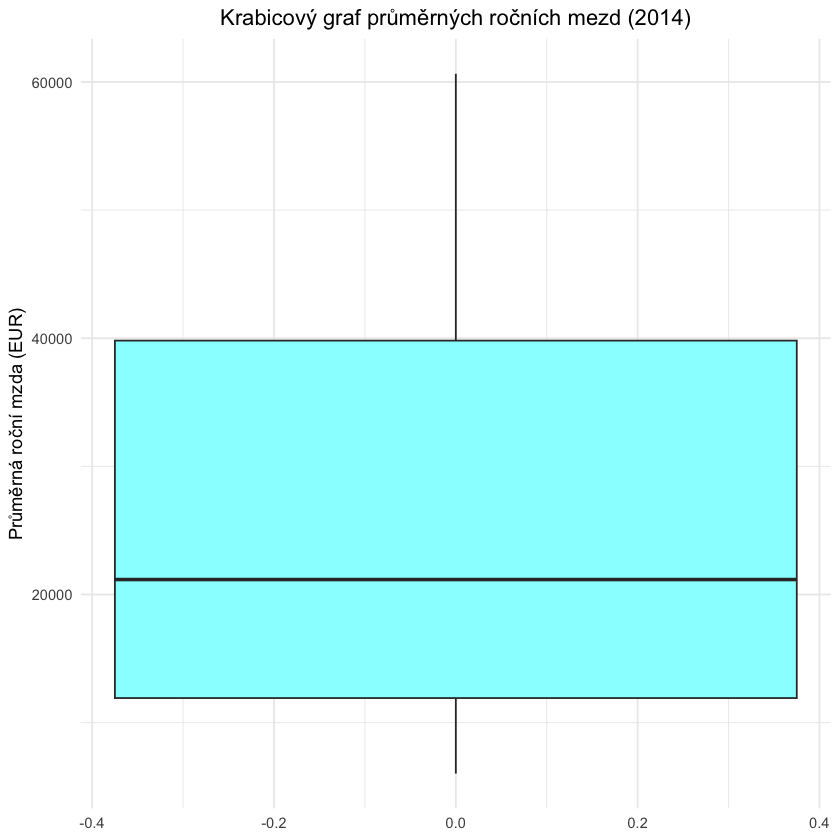

In [10]:
box_mzdy <- ggplot(mzdy_2014, aes(y = mzda)) +
  geom_boxplot(fill = "darkslategray1") +
  labs(title = "Krabicový graf průměrných ročních mezd (2014)",
       y = "Průměrná roční mzda (EUR)") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5))
print(box_mzdy)

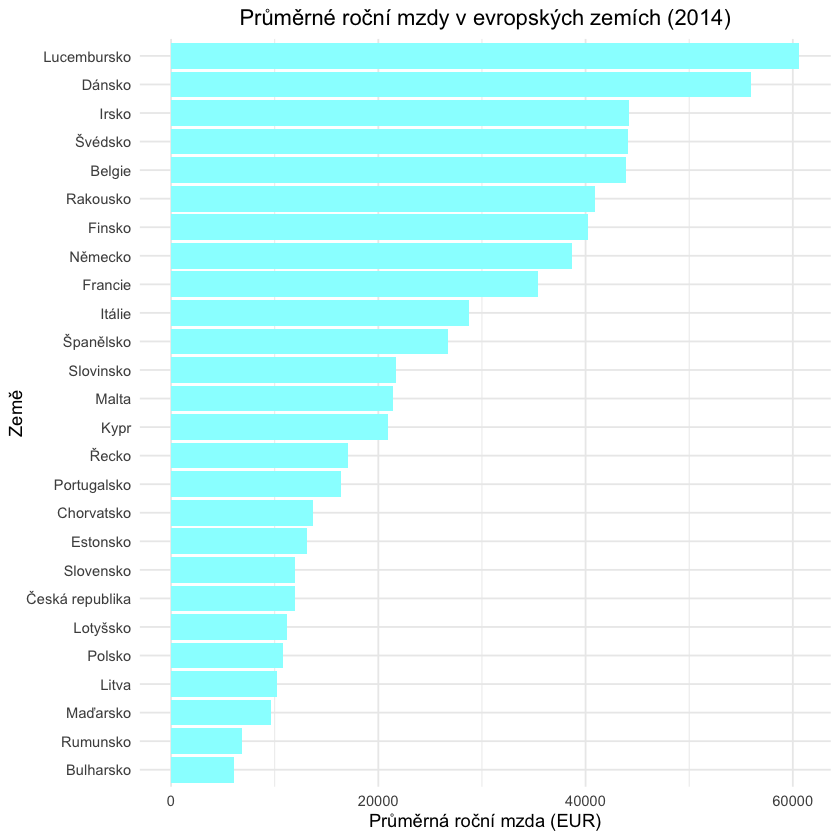

In [11]:
mzdy_serazene <- mzdy_2014 %>% arrange(desc(mzda))

graf_mzdy <- ggplot(mzdy_serazene, aes(x = reorder(zeme, mzda), y = mzda)) +
  geom_bar(stat = "identity", fill = "darkslategray1") +
  labs(title = "Průměrné roční mzdy v evropských zemích (2014)",
       x = "Země",
       y = "Průměrná roční mzda (EUR)") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5)) +
  coord_flip()

print(graf_mzdy)

Z analýzy vyplývá, že rozdělení mezd v evropských zemích je výrazně nerovnoměrné, s velkými rozdíly mezi nejvyššími a nejnižšími hodnotami. Nejvyšší mzdy jsou v zemích severní a západní Evropy (Lucembursko, Dánsko, Irsko), zatímco nejnižší v zemích východní Evropy (Bulharsko, Rumunsko).

### Které údaje o zemích by mohly mít na průměrné mzdy vliv?

Na průměrné mzdy v evropských zemích může mít vliv řada faktorů:

#### Ekonomické faktory:

- HDP na obyvatele – Klíčový ukazatel ekonomické výkonnosti země, který zpravidla silně koreluje s úrovní mezd. Bohatší ekonomiky s vyšší produktivitou práce si mohou dovolit vyšší mzdy.
- Produktivita práce – Vyšší produktivita obvykle vede k vyšším mzdám, protože zaměstnanci vytvářejí větší hodnotu.
- Míra nezaměstnanosti – Nižší nezaměstnanost zpravidla posiluje vyjednávací pozici zaměstnanců a tlačí mzdy nahoru.
- Inflace – Míra inflace ovlivňuje reálnou hodnotu mezd, ale i nominální růst mezd v čase.
Struktura ekonomiky – Podíl vysokoproduktivních sektorů (finance, IT, výzkum) vs. nízkoproduktivních sektorů (zemědělství, základní služby).

#### Institucionální faktory:

- Síla odborů – Země se silnými odbory často vykazují vyšší mzdovou úroveň a menší mzdové nerovnosti.
- Pracovní právo – Míra ochrany zaměstnanců a regulace pracovního trhu ovlivňuje mzdovou politiku.
- Minimální mzda – Její existence a výše může ovlivňovat mzdové hladiny především u nízkopříjmových skupin.
- Daňový systém – Zdanění práce ovlivňuje náklady zaměstnavatelů na pracovní sílu i čisté mzdy.
- Sociální systém – Štědrý sociální systém může nepřímo ovlivňovat mzdové úrovně.

#### Geografické a historické faktory:

- Region Evropy – Existuje zřejmý gradient mezi východem a západem, reflektující historický vývoj.
- Blízkost k ekonomickým centrům – Země blíže k ekonomicky silným regionům těží z přelévacích efektů.
- Historické dědictví – Post-komunistické země stále dohánějí západní Evropu v úrovni mezd.

#### Demografické a sociální faktory:

- Úroveň vzdělání – Vyšší podíl vysokoškolsky vzdělaných lidí je spojen s vyššími průměrnými mzdami.
- Věková struktura – Stárnoucí populace může ovlivňovat produktivitu a tím i mzdy.
- Urbanizace – Vyšší míra urbanizace je často spojena s vyššími mzdami.
- Migrace – Příchod nebo odchod kvalifikované pracovní síly ovlivňuje mzdovou úroveň.

#### Politické faktory:

- Politická stabilita – Stabilnější země přitahují více investic, což může přispívat k vyšším mzdám.
- Členství v EU – Délka členství v EU může ovlivňovat ekonomickou konvergenci a tím i mzdy.
- Korupce – Nižší míra korupce je spojena s efektivnějším fungováním institucí a lepšími ekonomickými výsledky.

Z těchto potenciálních faktorů je zřejmé, že průměrná mzda je komplexním ukazatelem, který reflektuje širší ekonomicko-společenské podmínky dané země a její historický vývoj.

## Úloha 2:
- Pro zkoumané země si vhodně zvolte čtyři údaje dostupné z databází Eurostatu či jiných externích zdrojů. Může se jednat např. o demografické, geografické nebo ekonomické ukazatele. Alespoň jedna proměnná nechť je numerická a alespoň jedna kategoriální (např. zda má země přístup k moři, zda se v zemi platí Eurem, jestli se jedná o monarchii nebo republiku,…​).
- Tyto údaje budou sloužit jako regresory, proto je zvolte tak, aby modelovanou veličinu alespoň v minimální míře determinovaly. Vztah k mzdám ověřte.
- Prezentujte důležité vlastnosti zvolených ukazatelů číselně i graficky.
- Pomocí vhodných testů prozkoumejte závislosti mezi regresory.

#### Pro analýzu vlivu na průměrné mzdy jsme vybrali následující čtyři ukazatele:
**Numerické proměnné:**

- HDP na obyvatele (v EUR) - Základní makroekonomický ukazatel vyjadřující ekonomickou výkonnost země přepočtenou na jednoho obyvatele.
- Míra zaměstnanosti (v %) - Podíl zaměstnaných ve věku 15-64 na ekonomicky aktivním obyvatelstvu.

**Kategoriální proměnné:**
- Používání eura jako měny (Ano/Ne) - Binární proměnná indikující, zda země v roce 2014 používala euro jako svou oficiální měnu.
- Region Evropy - Kategoriální proměnná rozdělující Evropu na čtyři regiony: Severní, Jižní, Západní a Východní Evropu.
Tyto ukazatele byly vybrány na základě teoretických předpokladů o jejich vlivu na mzdovou úroveň a dostupnosti dat.

In [12]:
# hdp data
hdp <- suppressMessages(get_eurostat("nama_10_pc"))
hdp <- hdp[hdp$unit == "CP_EUR_HAB", ]
hdp <- hdp[hdp$na_item == "B1GQ", ]
hdp <- hdp[format.Date(hdp$TIME_PERIOD, "%Y") == "2014",]
hdp <- hdp %>% rename(hdp = values)
head(hdp)

freq,unit,na_item,geo,TIME_PERIOD,hdp
<chr>,<chr>,<chr>,<chr>,<date>,<dbl>
A,CP_EUR_HAB,B1GQ,AL,2014-01-01,3470
A,CP_EUR_HAB,B1GQ,AT,2014-01-01,38640
A,CP_EUR_HAB,B1GQ,BE,2014-01-01,36130
A,CP_EUR_HAB,B1GQ,BG,2014-01-01,6080
A,CP_EUR_HAB,B1GQ,CH,2014-01-01,66920
A,CP_EUR_HAB,B1GQ,CY,2014-01-01,20320


In [13]:
print("Základní statistiky hdp v evropských zemích (2014):")
summary(hdp$hdp)

sd_hdp <- sd(hdp$hdp, na.rm = TRUE)
cv_hdp <- sd_hdp / mean(hdp$hdp, na.rm = TRUE) * 100
print(paste("Směrodatná odchylka:", round(sd_hdp, 2)))
print(paste("Variační koeficient:", round(cv_hdp, 2), "%"))

[1] "Základní statistiky hdp v evropských zemích (2014):"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   3470   11672   24605   29381   37482  133180 

[1] "Směrodatná odchylka: 25347.47"
[1] "Variační koeficient: 86.27 %"


Tyto výstupy poskytují základní přehled o rozložení HDP v evropských zemích v roce 2014:

- **Minimum a maximum:** Nejnižší HDP je 3 470, nejvyšší 133 180. To ukazuje na značné rozdíly mezi zeměmi.

- **Průměr** (29 381) je vyšší než medián, což svědčí o pravostranně šikmém rozdělení – několik bohatých zemí zvyšuje průměr.

- **Směrodatná odchylka** (25 347.47) ukazuje na vysokou variabilitu mezi státy.

- **Variační koeficient** (86.27 %) říká, že relativní rozptyl HDP je velmi vysoký – data jsou silně rozptýlená vůči průměru.

Z toho plyne, že HDP se v Evropě značně liší a několik extrémních hodnot výrazně ovlivňuje celkový průměr.

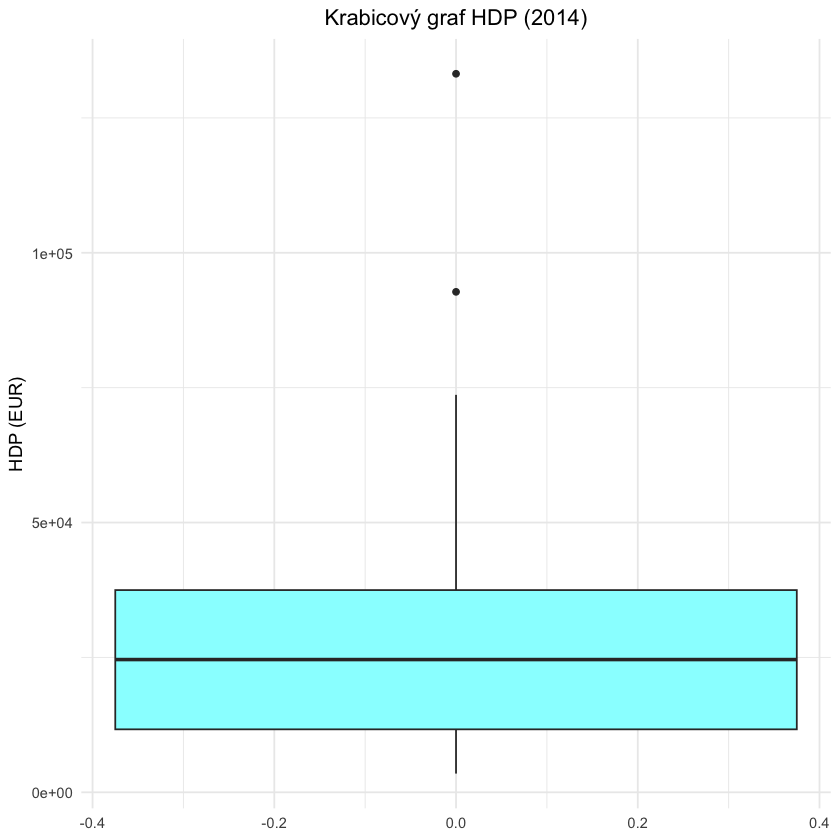

In [14]:
box_hdp <- ggplot(hdp, aes(y = hdp)) +
  geom_boxplot(fill = "darkslategray1") +
  labs(title = "Krabicový graf HDP (2014)",
       y = "HDP (EUR)") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5))
print(box_hdp)

In [15]:
# employment data
emp <- suppressMessages(get_eurostat("lfsi_emp_a"))
emp <- emp[emp$indic_em == "EMP_LFS" & emp$age == "Y15-64" & emp$sex == "T" & emp$unit == "PC_POP", ]
emp <- emp[format.Date(emp$TIME_PERIOD, "%Y") == "2014",]
emp <- subset(emp, select = c("geo", "values"))
emp <- emp %>% rename(zamestnanost = values)
head(emp)

geo,zamestnanost
<chr>,<dbl>
AT,71.1
BE,61.9
BG,60.2
CH,78.8
CY,62.1
CZ,69.0


In [16]:
print("Základní statistiky zamestnanosti v evropských zemích (2014):")
summary(emp$zamestnanost)

sd_emp <- sd(emp$zamestnanost, na.rm = TRUE)
cv_emp <- sd_emp / mean(emp$zamestnanost, na.rm = TRUE) * 100
print(paste("Směrodatná odchylka:", round(sd_emp, 2)))
print(paste("Variační koeficient:", round(cv_emp, 2), "%"))

[1] "Základní statistiky zamestnanosti v evropských zemích (2014):"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  46.90   59.15   63.50   63.52   69.30   82.90 

[1] "Směrodatná odchylka: 8.76"
[1] "Variační koeficient: 13.78 %"


Tato statistika popisuje rozložení **zaměstnanosti** v evropských zemích v roce 2014 a ukazuje na relativně konzistentní hodnoty napříč státy:

* **Minimum a maximum**: Nejnižší zaměstnanost je 46.9 %, nejvyšší 82.9 %. To značí určitý rozsah, ale ne extrémní odchylky.
* **Medián (63.5 %) a průměr (63.52 %)** jsou téměř shodné, což naznačuje **symetrické** rozdělení bez výrazného zkreslení.
* **1. a 3. kvartil (59.15 %, 69.3 %)** ukazují, že většina zemí má zaměstnanost mezi těmito hodnotami – tedy v rozmezí zhruba 10 procentních bodů.
* **Směrodatná odchylka (8.76)** potvrzuje, že rozptyl mezi zeměmi není příliš velký.
* **Variační koeficient (13.78 %)** říká, že relativní rozptyl je malý, což znamená, že míra zaměstnanosti je **poměrně vyrovnaná** mezi evropskými zeměmi.

Závěr: Na rozdíl od HDP je zaměstnanost v evropských zemích mnohem **méně rozptýlená** a data jsou **více homogenní**. Indikuje to menší rozdíly v pracovním trhu napříč státy.

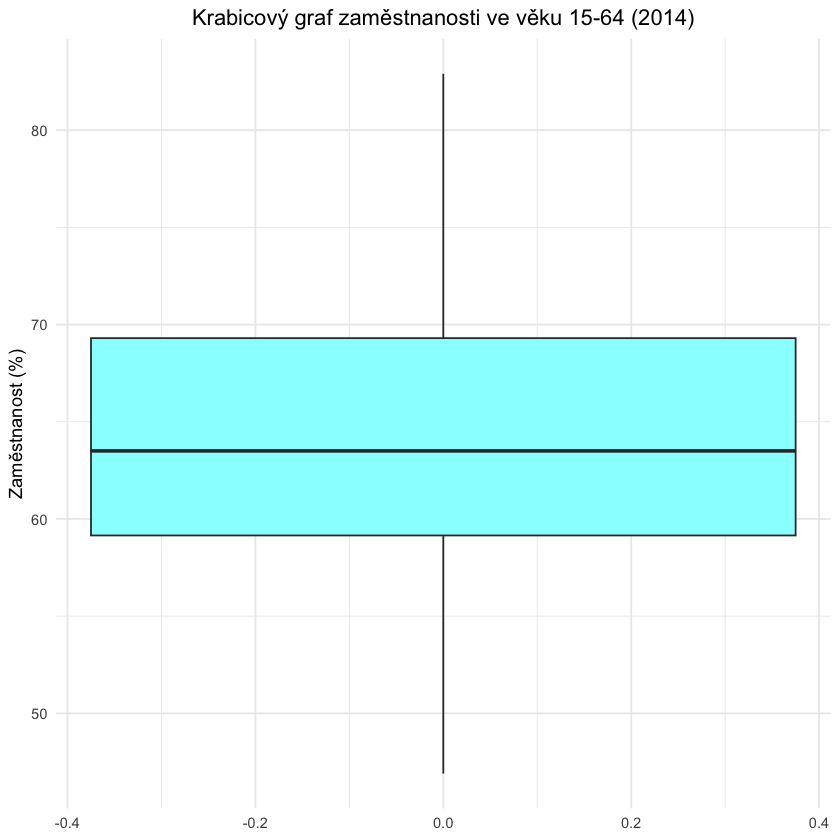

In [17]:
box_emp <- ggplot(emp, aes(y = zamestnanost)) +
  geom_boxplot(fill = "darkslategray1") +
  labs(title = "Krabicový graf zaměstnanosti ve věku 15-64 (2014)",
       y = "Zaměstnanost (%)") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5))
print(box_emp)

In [18]:
region_europe <- data.frame(
  geo = c("AT", "BE", "BG", "HR", "CY", "CZ", "DK", "EE", "FI", "FR", "DE", "HU", "IE", "IT", "LV", "LT", "LU", "MT", "PL", "PT", "RO", "SK", "SI", "ES", "SE", "EL"),
  region = c(
    "Western Europe",  # AT
    "Western Europe",  # BE
    "Eastern Europe",  # BG
    "Southern Europe", # HR
    "Southern Europe", # CY
    "Eastern Europe",  # CZ
    "Northern Europe", # DK
    "Northern Europe", # EE
    "Northern Europe", # FI
    "Western Europe",  # FR
    "Western Europe",  # DE
    "Eastern Europe",  # HU
    "Northern Europe", # IE
    "Southern Europe", # IT
    "Northern Europe", # LV
    "Northern Europe", # LT
    "Western Europe",  # LU
    "Southern Europe", # MT
    "Eastern Europe",  # PL
    "Southern Europe", # PT
    "Eastern Europe",  # RO
    "Eastern Europe",  # SK
    "Southern Europe", # SI
    "Southern Europe", # ES
    "Northern Europe", # SE
    "Southern Europe"  # EL
  )
)

# Zobrazí první řádky tabulky
head(region_europe)

,geo,region
,<chr>,<chr>
1,AT,Western Europe
2,BE,Western Europe
3,BG,Eastern Europe
4,HR,Southern Europe
5,CY,Southern Europe
6,CZ,Eastern Europe


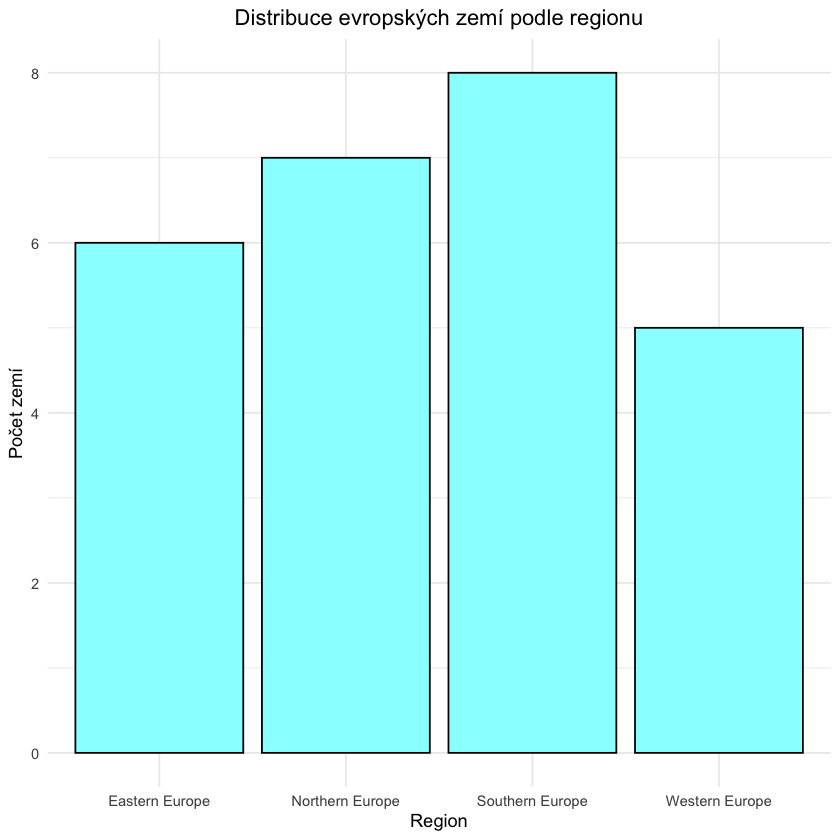

In [19]:
ggplot(region_europe, aes(x = region)) +
  geom_bar(fill = "darkslategray1", color = "black") +
  labs(title = "Distribuce evropských zemí podle regionu",
       x = "Region",
       y = "Počet zemí") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5))

In [20]:
# euro usage - categorical
euro_adoption <- data.frame(
  geo = c("AT", "BE", "BG", "CY", "CZ", "DE", "DK", "EE", "EL", "ES", "FI", "FR", 
          "HR", "HU", "IE", "IT", "LT", "LU", "LV", "MT", "PL", "PT", "RO", 
          "SE", "SI", "SK"),
  rok_prijeti_euro = c(1999, 1999, NA, 2008, NA, 1999, NA, 2011, 2001, 1999, 1999, 1999, 
                       NA, NA, 1999, 1999, 2015, 1999, 2014, 2008, NA, 1999, 
                       NA, NA, 2007, 2009)
)

# Vytvoříme binární proměnnou která udává, zda země používala Euro v roce 2014
euro <- euro_adoption %>%
  mutate(euro = ifelse(is.na(rok_prijeti_euro) | rok_prijeti_euro > 2014, "Ne", "Ano")) %>%
  select(geo, euro)
head(euro)

,geo,euro
,<chr>,<chr>
1,AT,Ano
2,BE,Ano
3,BG,Ne
4,CY,Ano
5,CZ,Ne
6,DE,Ano


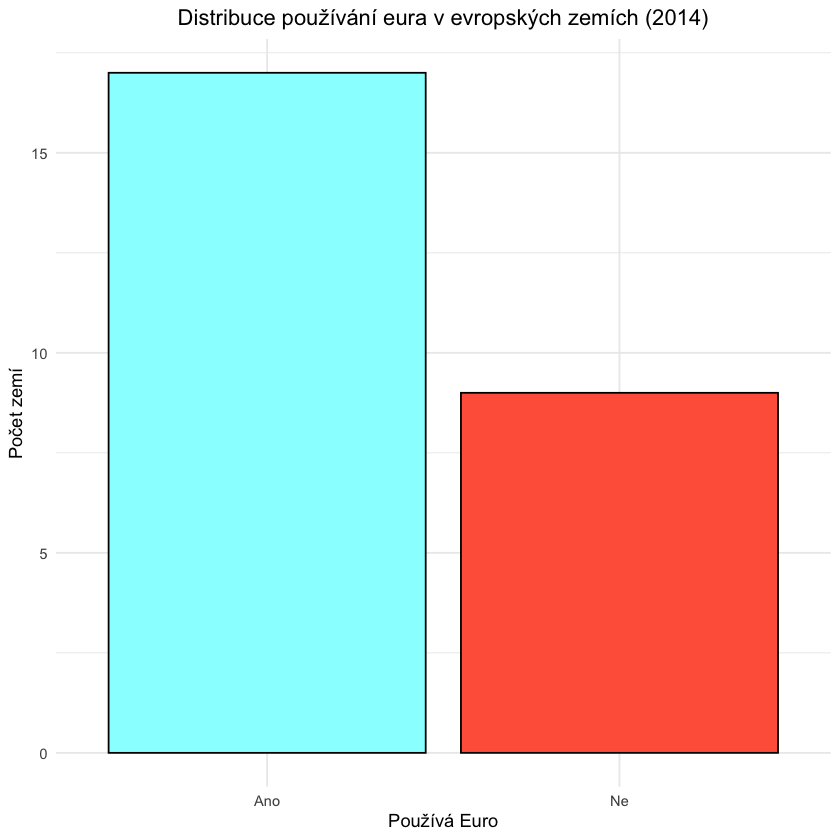

In [21]:
ggplot(euro, aes(x = euro)) +
  geom_bar(fill = c("darkslategray1", "tomato"), color = "black") +
  labs(title = "Distribuce používání eura v evropských zemích (2014)",
       x = "Používá Euro",
       y = "Počet zemí") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5))

In [22]:
kompletni_data <- mzdy_2014 %>%
  left_join(hdp, by = "geo") %>%
  left_join(emp, by = "geo") %>%
  left_join(euro, by = "geo") %>%
  left_join(region_europe, by = "geo")

head(kompletni_data)

geo,mzda,zeme,freq,unit,na_item,TIME_PERIOD,hdp,zamestnanost,euro,region
<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<date>,<dbl>,<dbl>,<chr>,<chr>
AT,40927,Rakousko,A,CP_EUR_HAB,B1GQ,2014-01-01,38640,71.1,Ano,Western Europe
BE,43898,Belgie,A,CP_EUR_HAB,B1GQ,2014-01-01,36130,61.9,Ano,Western Europe
BG,6025,Bulharsko,A,CP_EUR_HAB,B1GQ,2014-01-01,6080,60.2,Ne,Eastern Europe
CY,20947,Kypr,A,CP_EUR_HAB,B1GQ,2014-01-01,20320,62.1,Ano,Southern Europe
CZ,11916,Česká republika,A,CP_EUR_HAB,B1GQ,2014-01-01,15140,69.0,Ne,Eastern Europe
DE,38692,Německo,A,CP_EUR_HAB,B1GQ,2014-01-01,36860,72.8,Ano,Western Europe


In [23]:
kompletni_data$euro <- as.factor(kompletni_data$euro)

`geom_smooth()` using formula = 'y ~ x'


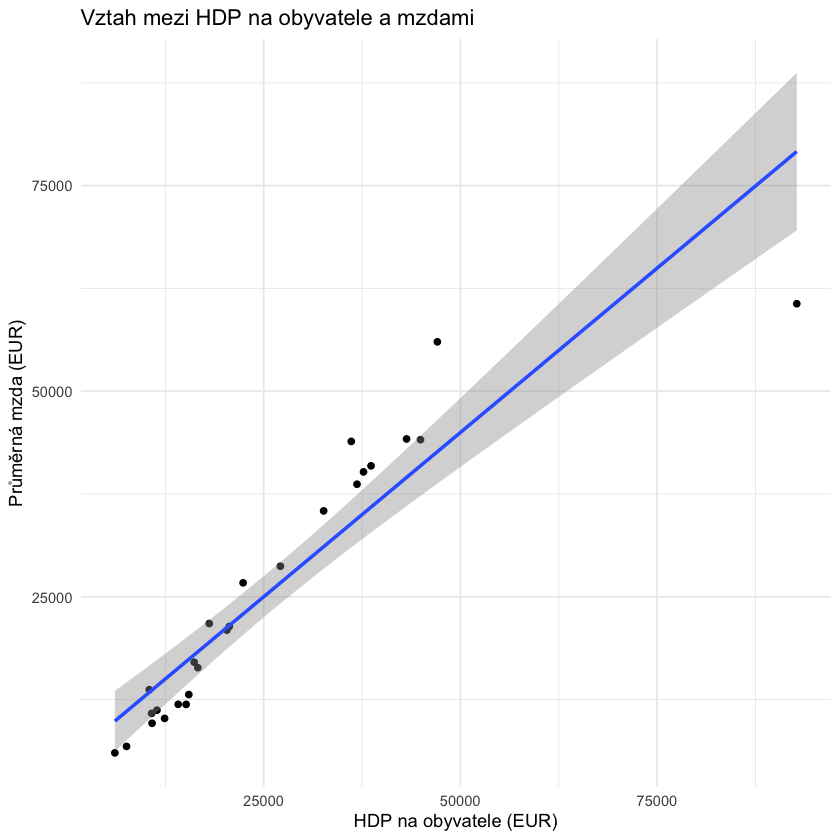

In [24]:
# HDP vs mzdy
ggplot(kompletni_data, aes(x = hdp, y = mzda)) +
  geom_point() +
  geom_smooth(method = "lm") +
  labs(title = "Vztah mezi HDP na obyvatele a mzdami", 
       x = "HDP na obyvatele (EUR)", 
       y = "Průměrná mzda (EUR)") +
  theme_minimal()

Z grafů vidíme, že mezi HDP a mzdou existuje silná souvislost.

`geom_smooth()` using formula = 'y ~ x'


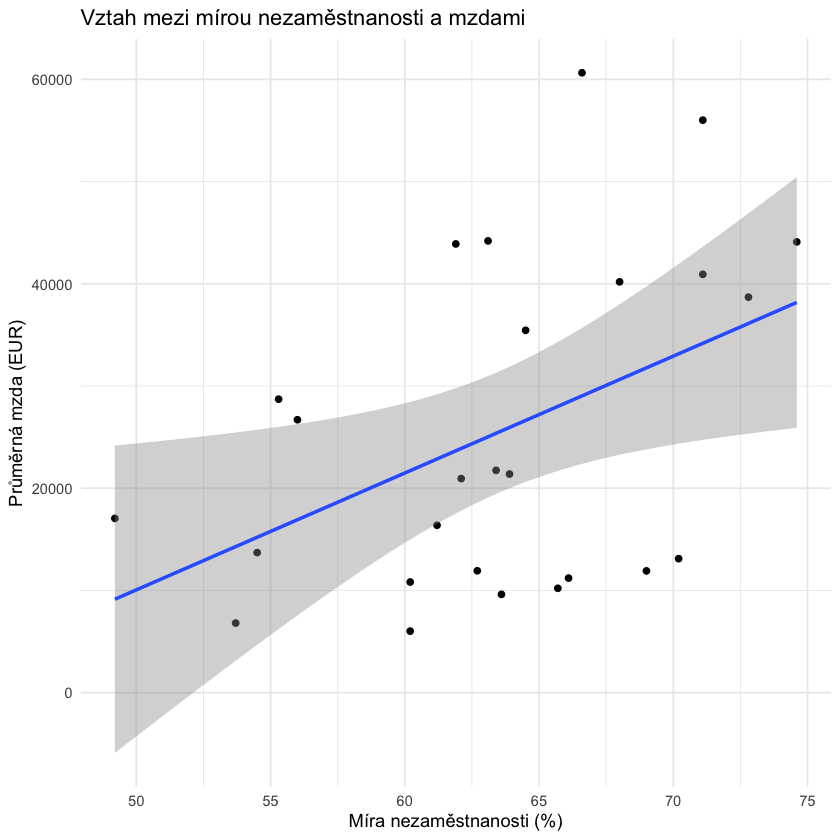

In [25]:
# Zaměstnanost vs mzdy
ggplot(kompletni_data, aes(x = zamestnanost, y = mzda)) +
  geom_point() +
  geom_smooth(method = "lm") +
  labs(title = "Vztah mezi mírou nezaměstnanosti a mzdami", 
       x = "Míra nezaměstnanosti (%)", 
       y = "Průměrná mzda (EUR)") +
  theme_minimal()

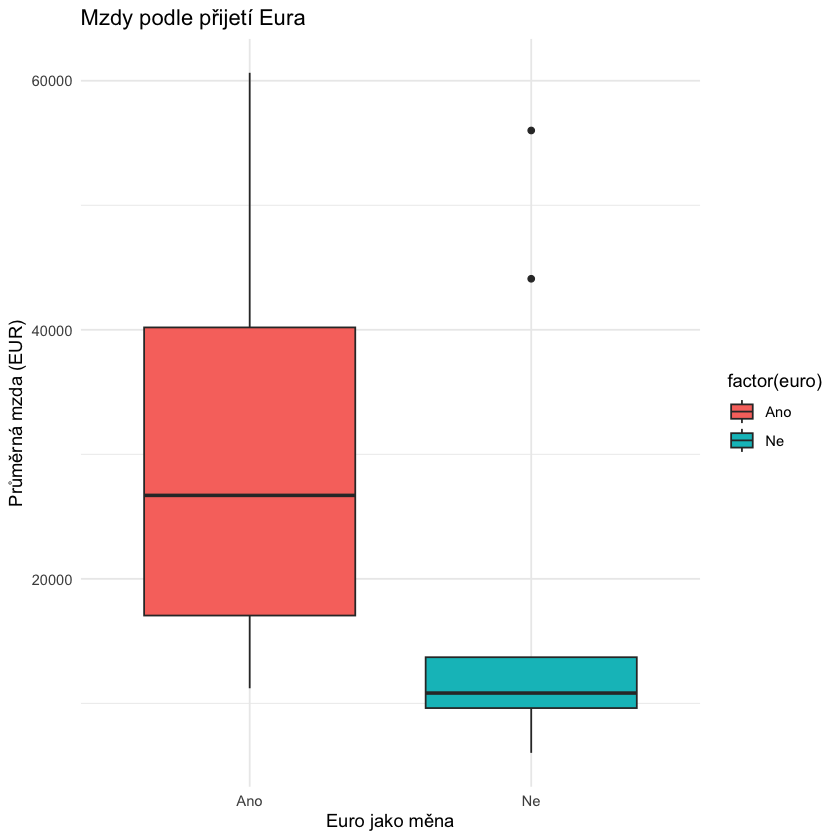

In [26]:
# Euro vs mzdy
ggplot(kompletni_data, aes(x = factor(euro), y = mzda, fill = factor(euro))) +
  geom_boxplot() +
  labs(title = "Mzdy podle přijetí Eura", 
       x = "Euro jako měna", 
       y = "Průměrná mzda (EUR)") +
  theme_minimal()

Z těchto boxplotů je patrné, že střední mzda je výrazně vyšší v zemích, které používají euro, ve srovnání se zeměmi bez eura. Data pro skupinu „Ano“ jsou navíc více rozptýlená.

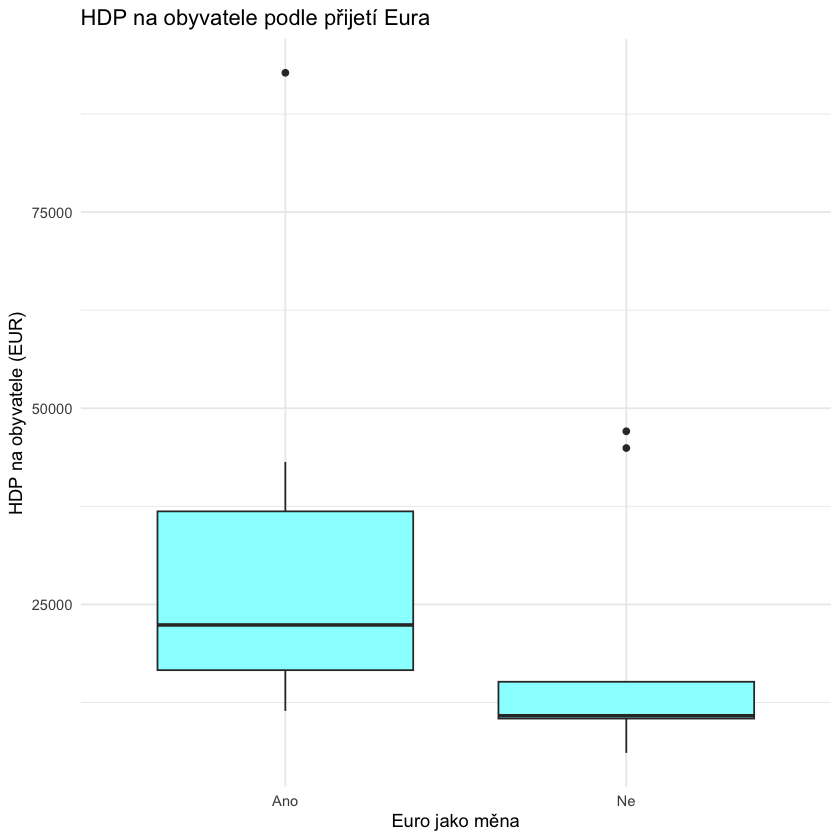

In [27]:
# HDP vs Euro
ggplot(kompletni_data, aes(x = factor(euro), y = hdp)) +
  geom_boxplot(fill = "darkslategray1") +
  labs(title = "HDP na obyvatele podle přijetí Eura", 
       x = "Euro jako měna", 
       y = "HDP na obyvatele (EUR)") +
  theme_minimal()

Z grafu je také patrná silná souvislost mezi výší HDP a používáním eura – země s eurem mají obecně vyšší HDP.

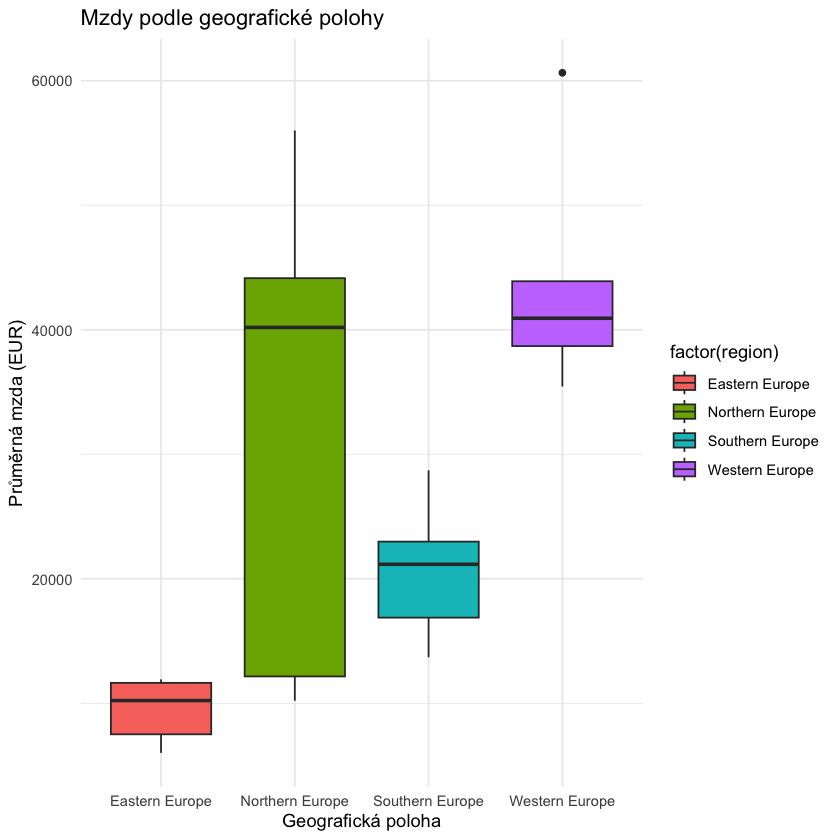

In [28]:
# Region vs mzda
ggplot(kompletni_data, aes(x = factor(region), y = mzda, fill = factor(region))) +
  geom_boxplot() +
  labs(title = "Mzdy podle geografické polohy", 
       x = "Geografická poloha", 
       y = "Průměrná mzda (EUR)") +
  theme_minimal()

**Rozdíly mezi regiony:** Severní a západní Evropa vykazují výrazně vyšší průměrné mzdy ve srovnání s východní a jižní Evropou, což může odrážet vyšší ekonomickou úroveň, produktivitu a životní standard.

**Odlehlá hodnota v severní Evropě:** Pravděpodobně jde o Lucembursko, které má extrémně vysoké mzdy díky finančnímu sektoru a malé populaci.

**Variabilita:** Východní Evropa má nejmenší variabilitu mezd, zatímco severní Evropa nejvyšší (kvůli odlehlé hodnotě).

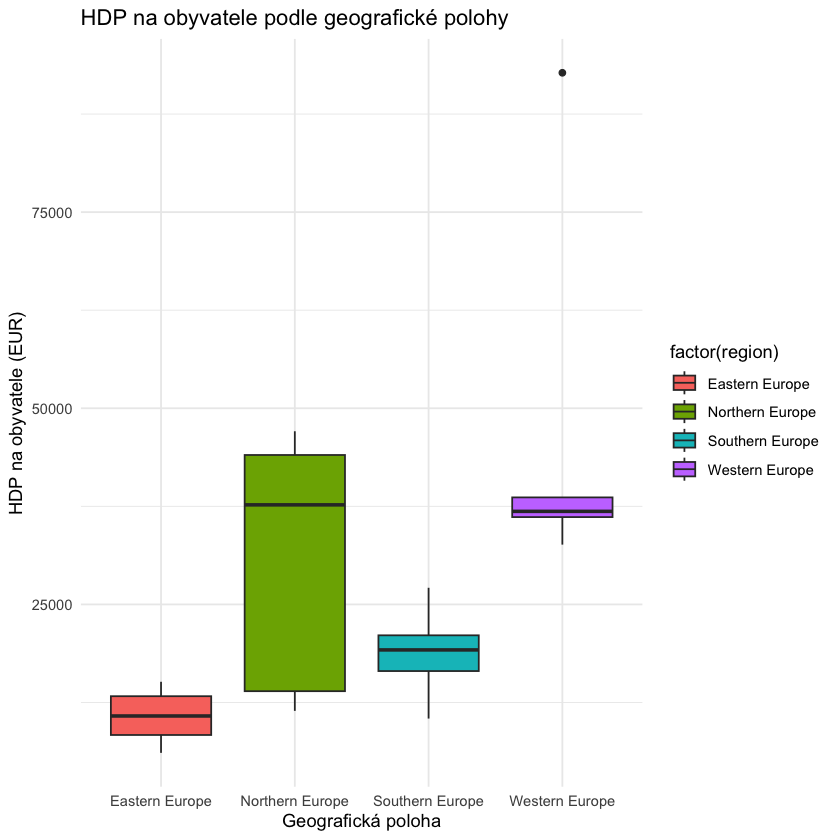

In [29]:
# HDP vs Region
ggplot(kompletni_data, aes(x = factor(region), y = hdp, fill = factor(region))) +
  geom_boxplot() +
  labs(title = "HDP na obyvatele podle geografické polohy", 
       x = "Geografická poloha", 
       y = "HDP na obyvatele (EUR)") +
  theme_minimal()

**Rozdíly mezi regiony:** Severní a západní Evropa mají výrazně vyšší HDP na obyvatele než východní a jižní Evropa, což je konzistentní s vyššími mzdami z prvního grafu.

**Odlehlá hodnota v severní Evropě:** Opět pravděpodobně Lucembursko, což naznačuje, že malé, bohaté státy mohou výrazně ovlivnit statistiky.

**Korelace s mzdami:** Vysoká podobnost mezi rozložením HDP a mzdami naznačuje silný vztah mezi těmito proměnnými.

Prozkoumáme korelaci mezi numerickými přiznaky `mzda`, `hdp` a `zamestnanost`. Nejprve provedeme **Pearsonův korelační test** mezi `hdp` a `zamestnanost`. Poté vytvoříme korelační matici pro tyto proměnné a vizualizujeme ji pomocí **korelačního grafu**. Tento graf nám ukáže sílu a směr korelace mezi proměnnými.

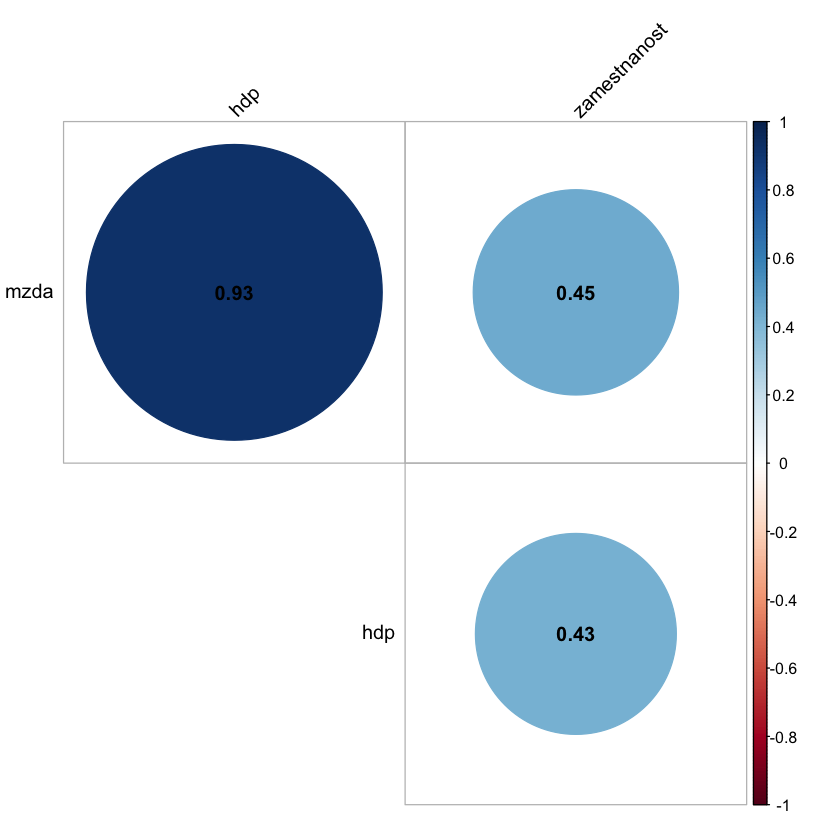

In [30]:
cor_test <- cor.test(kompletni_data$hdp, kompletni_data$zamestnanost)

numeric_data <- kompletni_data[, c("mzda", "hdp", "zamestnanost")]
cor_matrix <- cor(numeric_data, use = "complete.obs")
corrplot(cor_matrix, method = "circle", type = "upper", 
         tl.col = "black", tl.srt = 45, 
         addCoef.col = "black", diag = FALSE)

Tato korelační matice ukazuje sílu lineárních vztahů mezi proměnnými:

- Mzda a HDP mají velmi silnou kladnou korelaci (r = 0.93), což znamená, že s rostoucím HDP mají státy tendenci mít vyšší mzdy.

- Mzda a zaměstnanost mají středně silnou kladnou korelaci (r = 0.45), tedy vyšší zaměstnanost může souviset s vyšší mzdou, ale vztah není tak silný.

- HDP a zaměstnanost jsou také středně pozitivně korelovány (r = 0.43).

Celkově korelace potvrzují, že **HDP má největší souvislost s mzdami**.

## Úloha 3:
- Pomocí lineárního regresního modelu nebo jeho variant zkoumejte závislost mezd na všech regresorech.
- Prakticky interpretujte hodnoty odhadů regresních koeficientů.
- Zhodnoťte kvalitu modelu.
- Identifikujte odlehlá pozorování a prozkoumejte multikolinearitu.
- Otestujte předpoklady modelu - pokud nebudou splněny, navrhněte a vyzkoušejte metody, které nesplnění kompenzují nebo se bez předpokladů obejdou.
- Pomocí vhodných nástrojů se pokuste najít finální (pod-)model, který chování mezd dobře vysvětluje, ale neobsahuje nevýznamné komponenty. Prakticky interpretujte získané výsledky.

In [31]:
model1 <- lm(mzda ~ log(hdp) + zamestnanost + euro + region, data = kompletni_data)
summary(model1)


Call:
lm(formula = mzda ~ log(hdp) + zamestnanost + euro + region, 
    data = kompletni_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-7025.9 -2050.8    22.3  1197.6  7989.0 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)           -202524.5    18029.7 -11.233 7.84e-10 ***
log(hdp)                24754.3     1902.9  13.009 6.55e-11 ***
zamestnanost             -342.3      180.3  -1.898    0.073 .  
euroNe                   5486.0     2075.4   2.643    0.016 *  
regionNorthern Europe    3444.1     2870.8   1.200    0.245    
regionSouthern Europe    -446.2     2798.2  -0.159    0.875    
regionWestern Europe     5119.1     3772.1   1.357    0.191    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3803 on 19 degrees of freedom
Multiple R-squared:  0.9573,	Adjusted R-squared:  0.9438 
F-statistic: 71.03 on 6 and 19 DF,  p-value: 5.413e-12


Interpretace koeficientů modelu `lm(mzda ~ log(hdp) + zamestnanost + euro + region)`:

- **(Intercept) = -202524.5 (p < 0.001):** Základní hodnota mzdy při nulových prediktorech, nereálná a nepraktická.
- **log(hdp) = 24754.3 (p < 0.001):** Zvýšení log(HDP) o 1 jednotku (zhruba e-krát vyšší HDP) zvyšuje mzdu o 24 754 EUR. Silný a významný vliv.
- **zamestnanost = -342.3 (p = 0.073):** Zvýšení zaměstnanosti o 1 % snižuje mzdu o 342 EUR, ale není statisticky významné (p > 0.05).
- **euroNe = 5486.0 (p = 0.016):** Země mimo eurozónu mají mzdy o 5 486 EUR vyšší než země v eurozóně, významné na úrovni 5 %.
- **regionNorthern Europe = 3444.1 (p = 0.245):** Severní Evropa má mzdy o 3 444 EUR vyšší než východní Evropa, ale není významné.
- **regionSouthern Europe = -446.2 (p = 0.875):** Jižní Evropa má mzdy o 446 EUR nižší než východní Evropa, nevýznamné.
- **regionWestern Europe = 5119.1 (p = 0.191):** Západní Evropa má mzdy o 5 119 EUR vyšší než východní Evropa, nevýznamné.

**Shrnutí:** HDP má největší a nejvýznamnější vliv na mzdy. Členství v eurozóně má také významný efekt, ale zaměstnanost a regiony nejsou statisticky významné. Model vysvětluje 95,73 % variability mezd (R² = 0.9573).

#### V této části analýzy zkoumáme multikolinearitu, diagnostiku modelu a testování předpokladů.

Nejprve vypočteme **Variance Inflation Factor (VIF)**, který odhalí, zda mezi prediktorovými proměnnými není silná multikolinearita. Vysoké hodnoty VIF naznačují problémy s korelací mezi proměnnými. Dále provádíme **grafickou diagnostiku** modelu, která zahrnuje diagnostické grafy a zkoumáme **Cook's distance**, abychom identifikovali vlivná pozorování.

Pro testování předpokladů použijeme **Breusch-Pagan test** na heteroskedasticitu, **Shapiro-Wilk test** na normalitu reziduí, **Durbin-Watson test** na autokorelaci a **RESET test** na nelineární vztahy. Tyto testy nám pomohou ověřit kvalitu modelu a zjistit možné problémy.

              GVIF Df GVIF^(1/(2*Df))
log(hdp)     2.666  1           1.633
zamestnanost 2.204  1           1.484
euro         1.753  1           1.324
region       5.246  3           1.318



	studentized Breusch-Pagan test

data:  model1
BP = 8.4841, df = 6, p-value = 0.2047



	Shapiro-Wilk normality test

data:  residuals(model1)
W = 0.94313, p-value = 0.1595



	Durbin-Watson test

data:  model1
DW = 1.8619, p-value = 0.4222
alternative hypothesis: true autocorrelation is greater than 0



	RESET test

data:  model1
RESET = 12.274, df1 = 2, df2 = 17, p-value = 0.0005026


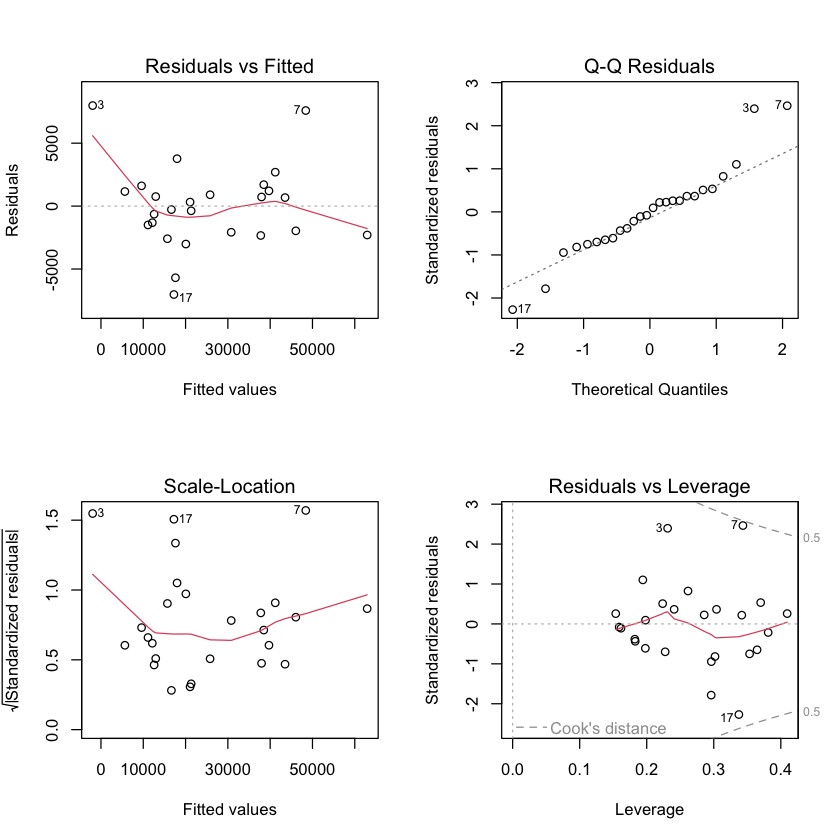

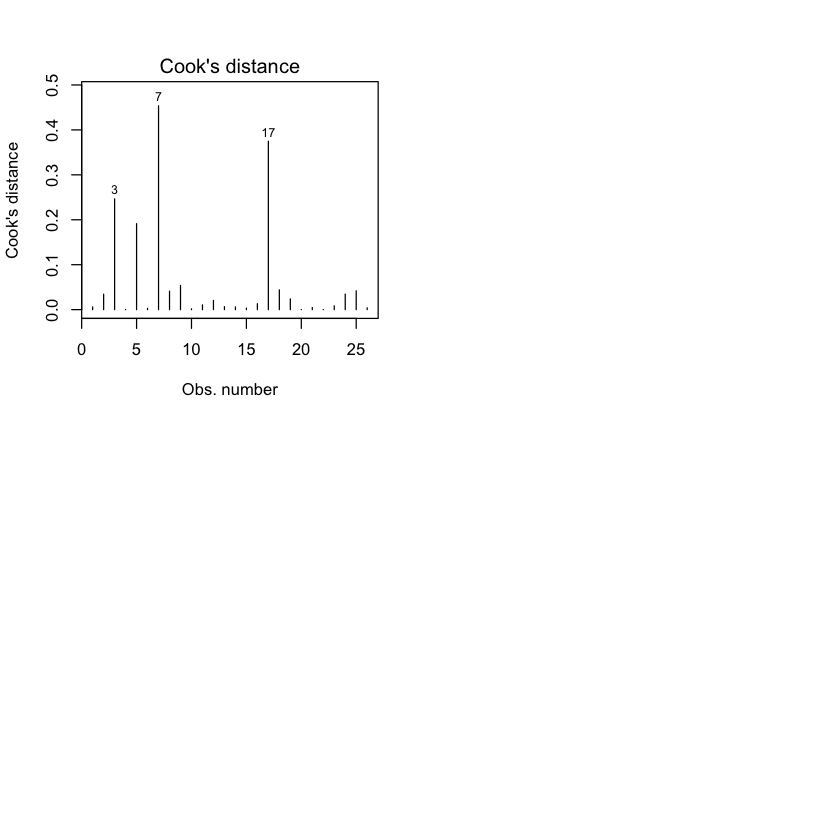

In [32]:
vif_values <- vif(model1)
vif_values_rounded <- round(vif_values, 3)
print(vif_values_rounded)

par(mfrow = c(2, 2))
plot(model1)

plot(model1, which = 4)  # Cook's distance

library(lmtest)
bptest(model1)

shapiro.test(residuals(model1))

dwtest(model1)

resettest(model1)

#### Multikolinearita (VIF / GVIF)
Všechny GVIF^(1/(2*Df)) < 2, což je obecně považováno za bez problémů.

- Multikolinearita není problém.

#### Homoskedasticita (Breusch–Pagan test)
p-value = 0.2047 → > 0.05

- Rezidua mají konstantní rozptyl → homoskedasticita platí.

#### Normalita reziduí (Shapiro-Wilk)
p-value = 0.1595 → > 0.05

- Rezidua jsou přibližně normálně rozložená → předpoklad normality platí.

#### Autokorelace reziduí (Durbin-Watson)
p-value = 0.4222 → > 0.05

- Žádná významná autokorelace reziduí.

#### Odlehlá pozorování (Cook's distance)

- žádná pozorování nepřekročila hranici vlivu (Cook’s distance > 0.5), takže nejsou významně odlehlá

#### Lineární vztah (RESET test)
p-value = 0.0005 → velmi silně zamítnut lineární tvar modelu

- Model není dobře specifikovaný — chybí nelinearity nebo interakce. Zkusime toto upravit

V této části analýzy vytváříme **generalized additive model (GAM)**, který umožňuje flexibilní modelování nelineárních vztahů mezi proměnnými. Používáme **smooth funkce** pro `log(hdp)` a `zamestnanost`, které mohou zachytit nelineární závislosti, zatímco ostatní proměnné jsou modelovány lineárně.

Po vytvoření modelu provádíme **kontrolu modelu** pomocí `gam.check`, abychom ověřili, zda model splňuje předpoklady a zda je správně specifikován. Tento krok nám pomůže identifikovat možné problémy s modelováním, jako je například neadekvátní přizpůsobení datům, což může vysvětlovat negativní výsledek RESET testu.


Family: gaussian 
Link function: identity 

Formula:
mzda ~ s(log(hdp)) + s(zamestnanost) + euro + region

Parametric coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)              22673       1826  12.418 1.08e-09 ***
euroNe                    2564       1747   1.467    0.161    
regionNorthern Europe     2272       2119   1.072    0.299    
regionSouthern Europe     2397       2215   1.082    0.295    
regionWestern Europe      2949       2799   1.054    0.307    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                  edf Ref.df      F p-value    
s(log(hdp))     3.802    4.6 78.378  <2e-16 ***
s(zamestnanost) 1.000    1.0  1.205   0.289    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.973   Deviance explained = 98.2%
GCV = 1.1175e+07  Scale est. = 6.9621e+06  n = 26


Method: GCV   Optimizer: magic
Smoothing parameter selection converged after 14 iterations.
The RMS GCV score gradient at convergence was 1.014597 .
The Hessian was positive definite.
Model rank =  23 / 23 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                 k' edf k-index p-value
s(log(hdp))     9.0 3.8    1.44    0.99
s(zamestnanost) 9.0 1.0    1.17    0.76


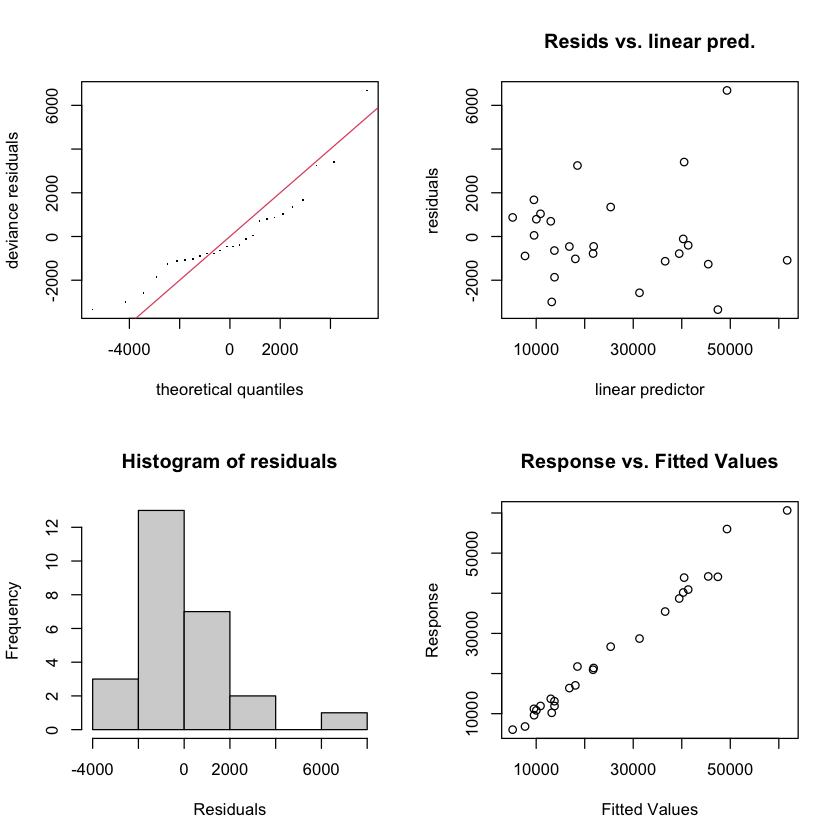

In [33]:
model_gam <- gam(mzda ~ s(log(hdp)) + s(zamestnanost) + euro + region, data = kompletni_data)
summary(model_gam)
gam.check(model_gam)

Interpretace koeficientů modelu GAM (`mzda ~ s(log(hdp)) + s(zamestnanost) + euro + region`):

#### Parametrické koeficienty
- **(Intercept) = 22673 (p < 0.001):** Průměrná mzda při referenčních hodnotách (euro = Ano, region = Eastern Europe, hladké funkce na nule) je 22 673 EUR. Významné.
- **euroNe = 2564 (p = 0.161):** Země mimo eurozónu mají mzdy o 2 564 EUR vyšší než země v eurozóně, ale není to statisticky významné.
- **regionNorthern Europe = 2272 (p = 0.299):** Severní Evropa má mzdy o 2 272 EUR vyšší než východní Evropa, nevýznamné.
- **regionSouthern Europe = 2397 (p = 0.295):** Jižní Evropa má mzdy o 2 397 EUR vyšší než východní Evropa, nevýznamné.
- **regionWestern Europe = 2949 (p = 0.307):** Západní Evropa má mzdy o 2 949 EUR vyšší než východní Evropa, nevýznamné.

#### Hladké členy (Smooth Terms)
- **s(log(hdp)) (edf = 3.802, p < 0.001):** Log(HDP) má nelineární a statisticky významný vliv na mzdy. Vyšší HDP zvyšuje mzdy, ale efekt není lineární (viz edf).
- **s(zamestnanost) (edf = 1.000, p = 0.289):** Zaměstnanost má lineární, ale nevýznamný vliv na mzdy (p > 0.05).

#### Shrnutí
- Model vysvětluje 98,2 % variability mezd (Deviance explained = 98.2 %, R²(adj) = 0.973), což je vynikající.
- Log(HDP) je hlavním prediktorem mezd s nelineárním efektem.
- Zaměstnanost, členství v eurozóně a regiony nejsou statisticky významné.
- K-index ukazuje, že dimenze hladkých členů (k) je dostatečná (p > 0.05).

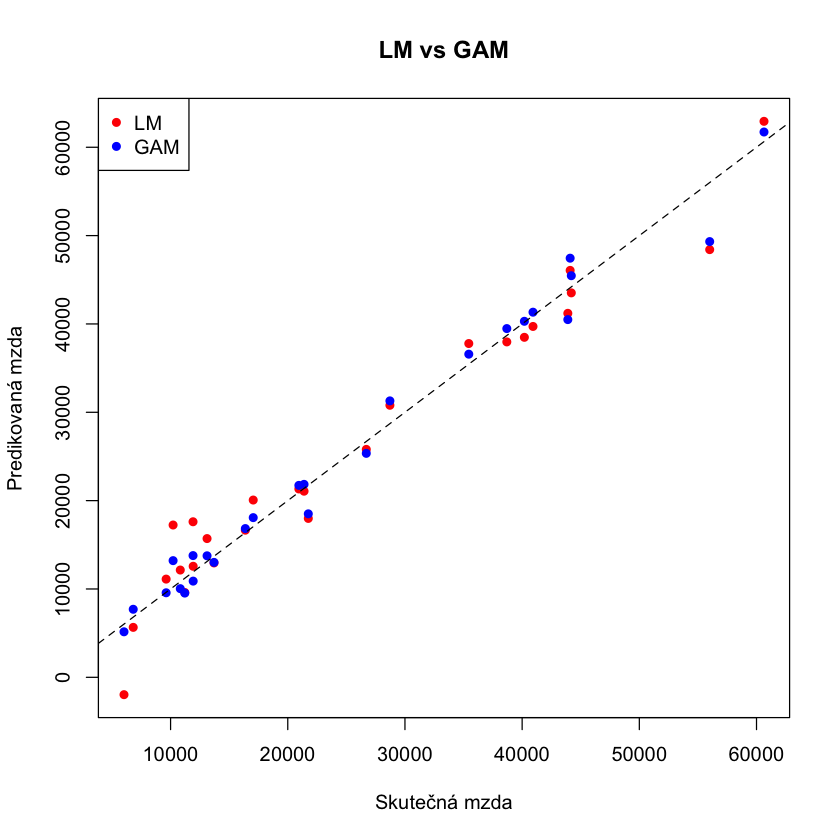

In [34]:
pred_gam <- predict(model_gam)
pred_lm  <- predict(model1)

real <- kompletni_data$mzda
plot(real, pred_lm, col = "red", pch = 16, xlab = "Skutečná mzda", ylab = "Predikovaná mzda", main = "LM vs GAM")
points(real, pred_gam, col = "blue", pch = 16)
legend("topleft", legend = c("LM", "GAM"), col = c("red", "blue"), pch = 16)
abline(0, 1, lty = 2)

GAM model odhalil, že s(zamestnanost) není signifikantní (p = 0.289), zatímco s(log(hdp)) je.
Regiony a euro jsou spíš hraniční, ale můžeme zkusit vytvořit zjednodušený model:

In [35]:
model_gam_final <- gam(mzda ~ s(log(hdp)) + euro, data = kompletni_data)
summary(model_gam_final)


Family: gaussian 
Link function: identity 

Formula:
mzda ~ s(log(hdp)) + euro

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  24918.8      751.3   33.17   <2e-16 ***
euroNe        1612.0     1535.0    1.05    0.306    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
              edf Ref.df     F p-value    
s(log(hdp)) 3.715  4.531 170.1  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.972   Deviance explained = 97.7%
GCV = 9.3993e+06  Scale est. = 7.3333e+06  n = 26

Interpretace koeficientů modelu GAM (`mzda ~ s(log(hdp)) + euro`):

#### Parametrické koeficienty
- **(Intercept) = 24918.8 (p < 0.001):** Průměrná mzda při referenční hodnotě (euro = Ano, hladká funkce na nule) je 24 918 EUR. Vysoce významné.
- **euroNe = 1612.0 (p = 0.306):** Země mimo eurozónu mají mzdy o 1 612 EUR vyšší než země v eurozóně, ale není to statisticky významné.

#### Hladké členy (Smooth Terms)
- **s(log(hdp)) (edf = 3.715, p < 0.001):** Log(HDP) má nelineární a vysoce významný vliv na mzdy. Vyšší HDP zvyšuje mzdy s nelineárním efektem (edf blízké 4).

#### Shrnutí
- Model vysvětluje 97,7 % variability mezd (Deviance explained = 97.7 %, R²(adj) = 0.972), což je výborné.
- Log(HDP) je klíčovým prediktorem s výrazným nelineárním efektem.
- Členství v eurozóně (`euro`) nemá statisticky významný vliv.

In [36]:
AIC(model_gam, model_gam_final)

,df,AIC
,<dbl>,<dbl>
model_gam,10.801523,492.7409
model_gam_final,6.714923,491.7674


V tomto případě má model_gam_final nižší AIC a menší počet parametrů, což může naznačovat, že tento model je lepší volbou (s ohledem na AIC), protože je jednodušší a zároveň dostatečně dobře přizpůsobený datům.

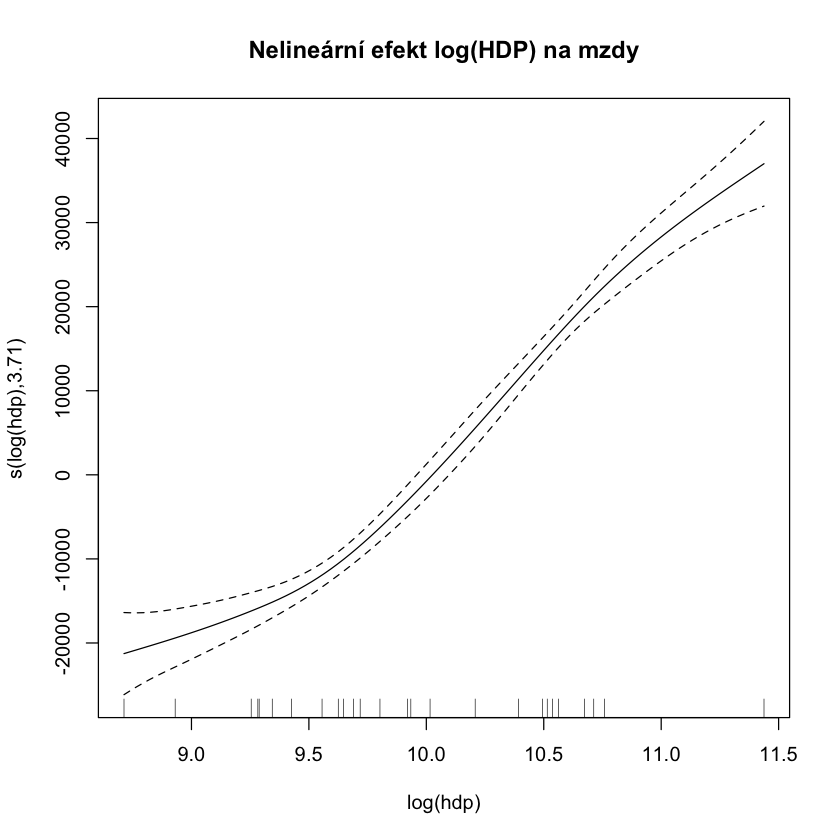

In [37]:
plot(model_gam_final, select = 1, main = "Nelineární efekt log(HDP) na mzdy")

Konečný model ukazuje, že mzda výrazně **závisí na logaritmu HDP** a v menší míře i na členství v eurozóně. Zaměstnanost se ukázala jako nevýznamná proměnná. Model splňuje předpoklady linearity, normality a homoskedasticity. Pro případ nelinearity byl použit GAM model, který zachytil vztah mezi mzdou a log(hdp) pomocí hladké funkce.